In [1]:
!pip install pennylane 
!pip install strawberryfields 
!pip install PennyLane-SF 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 15.0 MB/s eta 0:00:00

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from tqdm import tqdm

In [3]:
from sklearn.datasets import load_iris

import numpy as np
from sklearn.decomposition import PCA

import torch
from torch.autograd import Variable
import torch.optim as optim

# Import Data


In [4]:
num_features = 4
NUM_ZONES = 5

In [5]:
# X_feature_size = 4 # CHANGING VARIABLE
# iris = load_iris()
# X = iris.data[:, :X_feature_size]
# y = iris.target

data = np.load("data/data_5.npz", allow_pickle=True)["arr_0"][()]
X = np.array(data["pressure"])
y = np.array(data["zone_hits"]["data"])
num_sensors = X.shape[1]

pca = PCA(n_components = num_features)
pca.fit(X)
data_pca = pca.transform(X)
X = data_pca

num_data_points = 100
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
indices = indices[:num_data_points]
X = X[indices]
y = y[indices]

In [8]:
X.shape

(150, 4)

In [9]:
y.shape

(150,)

# Building Hybrid Quantum Model

In [28]:
np.random.seed(0)
torch.manual_seed(0)

num_zones = 2**NUM_ZONES # X zones - CHANGE
margin = 0.15
feature_size = num_features  
batch_size = 10 
lr_adam = 0.01
train_split = 0.75
# the number of the required qubits is calculated from the number of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 6
total_iterations = 50   # Maybe changes to 50

dev = qml.device("default.qubit", wires=num_qubits)

### Quantum Circuit

In [29]:
# a single layer represents one variational circuit
def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
        # Apply additional CNOT to entangle the last with the first qubit
        qml.CNOT(wires=[num_qubits - 1, 0])

In [30]:
def circuit(weights, feat=None):
    qml.AmplitudeEmbedding(feat, range(num_qubits), pad_with=0.0, normalize=True)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


qnodes = []
for iq in range(num_zones):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

In [31]:
def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

### Loss Function

In [32]:
def multiclass_svm_loss(q_circuits, all_params, feature_vecs, true_labels):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        # Compute the score given to this sample by the classifier corresponding to the
        # true label. So for a true label of 1, get the score computed by classifer 1,
        # which distinguishes between "class 1" or "not class 1".
        s_true = variational_classifier(
            q_circuits[int(true_labels[i])],
            (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]),
            feature_vec,
        )
        s_true = s_true.float()
        li = 0

        # Get the scores computed for this sample by the other classifiers
        for j in range(num_zones):
            if j != int(true_labels[i]):
                s_j = variational_classifier(
                    q_circuits[j], (all_params[0][j], all_params[1][j]), feature_vec
                )
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).float(), s_j - s_true + margin)
        loss += li

    return loss / num_samples

### Classification

In [33]:
def classify(q_circuits, all_params, feature_vecs, labels):
    predicted_labels = []
    raw_preds = []
    for i, feature_vec in enumerate(feature_vecs):
        scores = np.zeros(num_zones)
        for c in range(num_zones):
            score = variational_classifier(
                q_circuits[c], (all_params[0][c], all_params[1][c]), feature_vec
            )
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
        raw_preds.append(scores)
    return predicted_labels, raw_preds


def accuracy(labels, hard_predictions):
    loss = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / labels.shape[0]
    return loss

In [34]:
def process_data(X_data, y_data):
    X = torch.tensor(X_data)

    # normalize each input
    normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
    X_norm = X / normalization.reshape(len(X), 1)

    Y = torch.tensor(y_data)
    return X_norm, Y

### Training Procedure

In [35]:
def training(features, Y):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = train_test_split(features, Y, test_size= 1 - train_split, random_state=42)
    num_train = Y_train.shape[0]
    q_circuits = qnodes

    # Initialize the parameters
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_zones)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_zones)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc = [], [], []
    raw_train, raw_test = [], []

    # train the variational classifier
    for it in tqdm(range(total_iterations)):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train, raw_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test, raw_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)
        np.save("model_data.npz", {"test_acc": test_acc, "train_acc": train_acc, "costs":costs})

    return costs, train_acc, test_acc, raw_train, raw_test

In [36]:
features, Y = process_data(X, y)

In [37]:
features.shape

torch.Size([150, 4])

In [38]:
Y.shape

torch.Size([150])

In [39]:
# We now run our training algorithm and plot the results. Note that
# for plotting, the matplotlib library is required
costs, train_acc, test_acc, raw_train, raw_test = training(features, Y)

Num params:  111


  2%|▏         | 1/50 [02:14<1:50:07, 134.85s/it]

Iter:     1 | Cost: 4.4288359 | Acc train: 0.2053571 | Acc test: 0.2105263 


  4%|▍         | 2/50 [04:31<1:48:31, 135.65s/it]

Iter:     2 | Cost: 3.3154705 | Acc train: 0.2410714 | Acc test: 0.1315789 


  6%|▌         | 3/50 [06:49<1:47:13, 136.89s/it]

Iter:     3 | Cost: 3.2132154 | Acc train: 0.2857143 | Acc test: 0.2631579 


  8%|▊         | 4/50 [09:07<1:45:20, 137.41s/it]

Iter:     4 | Cost: 2.2787058 | Acc train: 0.3571429 | Acc test: 0.3947368 


 10%|█         | 5/50 [11:23<1:42:45, 137.01s/it]

Iter:     5 | Cost: 1.7366149 | Acc train: 0.4107143 | Acc test: 0.4210526 


 12%|█▏        | 6/50 [13:40<1:40:27, 137.00s/it]

Iter:     6 | Cost: 0.9914157 | Acc train: 0.4375000 | Acc test: 0.5263158 


 14%|█▍        | 7/50 [15:58<1:38:18, 137.17s/it]

Iter:     7 | Cost: 0.7547776 | Acc train: 0.4285714 | Acc test: 0.5000000 


 16%|█▌        | 8/50 [18:16<1:36:15, 137.52s/it]

Iter:     8 | Cost: 0.6298702 | Acc train: 0.4375000 | Acc test: 0.5000000 


 18%|█▊        | 9/50 [20:34<1:34:01, 137.60s/it]

Iter:     9 | Cost: 0.8084337 | Acc train: 0.4464286 | Acc test: 0.5000000 


 20%|██        | 10/50 [22:52<1:31:49, 137.73s/it]

Iter:    10 | Cost: 0.3313404 | Acc train: 0.4642857 | Acc test: 0.5263158 


 22%|██▏       | 11/50 [25:08<1:29:08, 137.14s/it]

Iter:    11 | Cost: 0.9140726 | Acc train: 0.4732143 | Acc test: 0.5263158 


 24%|██▍       | 12/50 [27:23<1:26:25, 136.45s/it]

Iter:    12 | Cost: 0.1893429 | Acc train: 0.4732143 | Acc test: 0.5526316 


 26%|██▌       | 13/50 [29:38<1:23:57, 136.14s/it]

Iter:    13 | Cost: 0.2575991 | Acc train: 0.4910714 | Acc test: 0.5526316 


 28%|██▊       | 14/50 [31:55<1:21:48, 136.36s/it]

Iter:    14 | Cost: 0.2749203 | Acc train: 0.4910714 | Acc test: 0.5526316 


 30%|███       | 15/50 [34:09<1:19:11, 135.74s/it]

Iter:    15 | Cost: 0.6008562 | Acc train: 0.5089286 | Acc test: 0.5526316 


 32%|███▏      | 16/50 [36:25<1:16:53, 135.69s/it]

Iter:    16 | Cost: 0.3162114 | Acc train: 0.5178571 | Acc test: 0.5526316 


 34%|███▍      | 17/50 [38:37<1:14:02, 134.61s/it]

Iter:    17 | Cost: 0.2224454 | Acc train: 0.5178571 | Acc test: 0.5526316 


 36%|███▌      | 18/50 [40:50<1:11:34, 134.20s/it]

Iter:    18 | Cost: 0.1854575 | Acc train: 0.5178571 | Acc test: 0.5526316 


 38%|███▊      | 19/50 [43:01<1:08:47, 133.13s/it]

Iter:    19 | Cost: 0.9744288 | Acc train: 0.5178571 | Acc test: 0.5526316 


 40%|████      | 20/50 [45:14<1:06:32, 133.09s/it]

Iter:    20 | Cost: 0.3624249 | Acc train: 0.5089286 | Acc test: 0.5263158 


 42%|████▏     | 21/50 [47:26<1:04:15, 132.94s/it]

Iter:    21 | Cost: 0.1665883 | Acc train: 0.5178571 | Acc test: 0.5263158 


 44%|████▍     | 22/50 [49:38<1:01:51, 132.56s/it]

Iter:    22 | Cost: 0.2626704 | Acc train: 0.5178571 | Acc test: 0.5263158 


 46%|████▌     | 23/50 [51:50<59:35, 132.43s/it]  

Iter:    23 | Cost: 0.1293939 | Acc train: 0.5267857 | Acc test: 0.5263158 


 48%|████▊     | 24/50 [54:03<57:26, 132.55s/it]

Iter:    24 | Cost: 0.2026543 | Acc train: 0.5357143 | Acc test: 0.5263158 


 50%|█████     | 25/50 [56:15<55:06, 132.28s/it]

Iter:    25 | Cost: 0.2432293 | Acc train: 0.5535714 | Acc test: 0.5263158 


 52%|█████▏    | 26/50 [58:27<52:52, 132.18s/it]

Iter:    26 | Cost: 0.3313170 | Acc train: 0.5535714 | Acc test: 0.5263158 


 54%|█████▍    | 27/50 [1:00:37<50:28, 131.66s/it]

Iter:    27 | Cost: 0.2169009 | Acc train: 0.5625000 | Acc test: 0.5263158 


 56%|█████▌    | 28/50 [1:02:47<48:04, 131.14s/it]

Iter:    28 | Cost: 0.2693613 | Acc train: 0.5714286 | Acc test: 0.5263158 


 58%|█████▊    | 29/50 [1:04:56<45:42, 130.59s/it]

Iter:    29 | Cost: 0.1756845 | Acc train: 0.5714286 | Acc test: 0.5263158 


 60%|██████    | 30/50 [1:07:05<43:22, 130.14s/it]

Iter:    30 | Cost: 0.2270500 | Acc train: 0.5714286 | Acc test: 0.5263158 


 62%|██████▏   | 31/50 [1:09:16<41:16, 130.33s/it]

Iter:    31 | Cost: 0.2024904 | Acc train: 0.5714286 | Acc test: 0.5263158 


 64%|██████▍   | 32/50 [1:11:25<38:57, 129.88s/it]

Iter:    32 | Cost: 0.1224893 | Acc train: 0.5714286 | Acc test: 0.5263158 


 66%|██████▌   | 33/50 [1:13:37<36:59, 130.57s/it]

Iter:    33 | Cost: 0.1746475 | Acc train: 0.5714286 | Acc test: 0.5263158 


 68%|██████▊   | 34/50 [1:15:50<34:57, 131.08s/it]

Iter:    34 | Cost: 0.3286285 | Acc train: 0.5714286 | Acc test: 0.5263158 


 70%|███████   | 35/50 [1:18:01<32:50, 131.34s/it]

Iter:    35 | Cost: 0.1137071 | Acc train: 0.5714286 | Acc test: 0.5263158 


 72%|███████▏  | 36/50 [1:20:17<30:57, 132.66s/it]

Iter:    36 | Cost: 0.2223815 | Acc train: 0.5714286 | Acc test: 0.5263158 


 74%|███████▍  | 37/50 [1:22:32<28:54, 133.39s/it]

Iter:    37 | Cost: 0.3080689 | Acc train: 0.5714286 | Acc test: 0.5263158 


 76%|███████▌  | 38/50 [1:24:47<26:43, 133.67s/it]

Iter:    38 | Cost: 0.2312610 | Acc train: 0.5714286 | Acc test: 0.5263158 


 78%|███████▊  | 39/50 [1:26:58<24:24, 133.11s/it]

Iter:    39 | Cost: 0.2594978 | Acc train: 0.5714286 | Acc test: 0.5263158 


 80%|████████  | 40/50 [1:29:11<22:08, 132.88s/it]

Iter:    40 | Cost: 0.1573314 | Acc train: 0.5714286 | Acc test: 0.5263158 


 82%|████████▏ | 41/50 [1:31:23<19:53, 132.65s/it]

Iter:    41 | Cost: 0.3034222 | Acc train: 0.5714286 | Acc test: 0.5000000 


 84%|████████▍ | 42/50 [1:33:34<17:38, 132.31s/it]

Iter:    42 | Cost: 0.2933733 | Acc train: 0.5714286 | Acc test: 0.5000000 


 86%|████████▌ | 43/50 [1:35:46<15:23, 131.99s/it]

Iter:    43 | Cost: 0.1437371 | Acc train: 0.5625000 | Acc test: 0.5000000 


 88%|████████▊ | 44/50 [1:37:57<13:11, 131.90s/it]

Iter:    44 | Cost: 0.2654243 | Acc train: 0.5714286 | Acc test: 0.5000000 


 90%|█████████ | 45/50 [1:40:07<10:56, 131.39s/it]

Iter:    45 | Cost: 0.1846772 | Acc train: 0.5625000 | Acc test: 0.5000000 


 92%|█████████▏| 46/50 [1:42:20<08:46, 131.73s/it]

Iter:    46 | Cost: 0.2207358 | Acc train: 0.5535714 | Acc test: 0.5000000 


 94%|█████████▍| 47/50 [1:44:33<06:36, 132.08s/it]

Iter:    47 | Cost: 0.1169485 | Acc train: 0.5535714 | Acc test: 0.5000000 


 96%|█████████▌| 48/50 [1:46:44<04:23, 131.85s/it]

Iter:    48 | Cost: 0.1990835 | Acc train: 0.5535714 | Acc test: 0.5000000 


 98%|█████████▊| 49/50 [1:48:57<02:12, 132.21s/it]

Iter:    49 | Cost: 0.1334530 | Acc train: 0.5535714 | Acc test: 0.5000000 


100%|██████████| 50/50 [1:51:10<00:00, 133.40s/it]

Iter:    50 | Cost: 0.2960711 | Acc train: 0.5535714 | Acc test: 0.5000000 


In [40]:
np.save("data/model_data_5.npy", {"test_acc": test_acc, "train_acc": train_acc, "costs":costs})

# Results

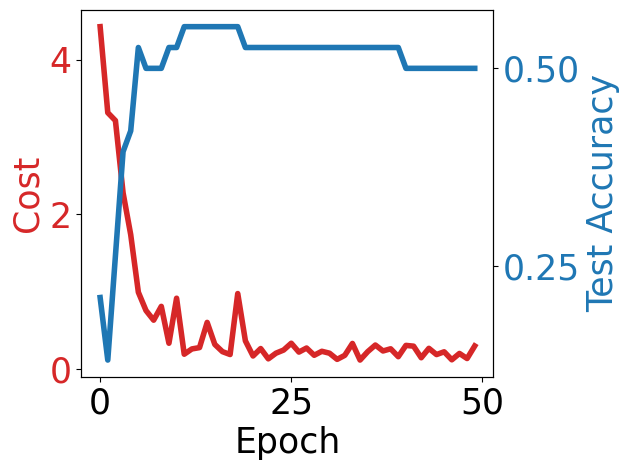

In [47]:
import matplotlib.pyplot as plt

crop = 50

fig, ax1 = plt.subplots()
iters = np.arange(0, crop, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Epoch", fontsize=25)
ax1.set_ylabel("Cost", fontsize=25, color=colors[0])
ax1.plot(iters, costs[:crop], color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=25, labelcolor=colors[0])
ax1.tick_params(axis="x", labelsize=25)
ax1.set_yticks([0.0, 2, 4.0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Accuracy", fontsize=25, color=colors[1])
ax2.plot(iters, test_acc[:crop], color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=25)
ax2.tick_params(axis="y", labelsize=25, labelcolor=colors[1])
ax2.set_xticks([0,25,50])
ax2.set_yticks([0.25, 0.5])

plt.grid(False)
plt.tight_layout()
plt.show()

### Other: Classical Neural Network

In [10]:
# def classicalNN(X, y, inputdim):
#   keras.backend.set_floatx('float64')
#   model = keras.models.Sequential([
#                                   layers.Dense(16, activation ="relu", input_dim = inputdim),  
#                                   #layers.Dense(64, activation ="relu", input_dim = 33), 
#                                   layers.Dense(16, activation ="relu")     # corresponds to the number of qubits we need
#                                   ])
#   model.summary()
#   model.compile(loss = 'mean_squared_error', metrics =['accuracy'], optimizer = 'adam')
#   #model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
#   model.fit(X, y, epochs = 30, batch_size = 64)
#   qvc_input = model.predict(X)
#   return qvc_input

# qvc_input = classicalNN(X, y, X_feature_size)

#opt = keras.optimizers.SGD(learning_rate = 0.002)
#model.compile(loss = 'mean_squared_error', metrics =['accuracy'], optimizer = 'adam')

#classical = model.fit(X, y,epochs = 30, batch_size = 64)

#qvc_input = model.predict(X)

# print(qvc_input.shape)

NameError: ignored